In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    average_precision_score
)
import shap
import random
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [23]:
# %%

# Configurações do Pandas e Matplotlib
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)


def carregar_dados_com_cache(nome_dataset, caminho_csv, url_api):
    if os.path.exists(caminho_csv):
        df = pd.read_csv(caminho_csv)
    else:
        try:
            df = pd.read_csv(url_api)
            df.to_csv(caminho_csv, index=False)
        except Exception as e:
            print(f"ERRO: Não foi possível buscar os dados da API para {nome_dataset}. Erro: {e}")
            return pd.DataFrame() # Retorna um DataFrame vazio em caso de erro

    print(f"{nome_dataset} carregado com sucesso. Shape: {df.shape}")
    return df

# --- DEFINIÇÃO DAS FONTES DE DADOS ---

# Nomes dos arquivos de cache que serão criados
KEPLER_CSV = 'nasa_data_kepler.csv'
TESS_CSV = 'nasa_data_tess.csv'
K2_CSV = 'nasa_data_k2.csv'

# URLs da API do NASA Exoplanet Archive
BASE_URL = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query="
KEPLER_QUERY = "select+*+from+cumulative"
TESS_QUERY = "select+*+from+toi"
K2_QUERY = "select+*+from+k2pandc"
FORMAT = "&format=csv"

# Montagem das URLs completas
kepler_url = f"{BASE_URL}{KEPLER_QUERY}{FORMAT}"
tess_url = f"{BASE_URL}{TESS_QUERY}{FORMAT}"
k2_url = f"{BASE_URL}{K2_QUERY}{FORMAT}"

# --- EXECUÇÃO DO CARREGAMENTO ---

kepler_df = carregar_dados_com_cache('Kepler', KEPLER_CSV, kepler_url)
tess_df = carregar_dados_com_cache('TESS', TESS_CSV, tess_url)
k2_df = carregar_dados_com_cache('K2', K2_CSV, k2_url)


Kepler carregado com sucesso. Shape: (9564, 153)
TESS carregado com sucesso. Shape: (7703, 91)
K2 carregado com sucesso. Shape: (4004, 361)


C:\Users\Guilherme\AppData\Local\Temp\ipykernel_15296\1175221431.py:11: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_csv)


In [24]:

# %%
# ==============================================================================
# 2. SELEÇÃO, RENOMEAÇÃO E PADRONIZAÇÃO
# ==============================================================================

# --- Processamento do Kepler (COM FILTRO DE AMBIGUIDADE) ---

# Disposições que queremos manter (alta confiança)
high_confidence_kepler = ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']
kepler_filtered_df = kepler_df.loc[kepler_df['koi_disposition'].isin(high_confidence_kepler)].copy()
print(f"Kepler: {len(kepler_df) - len(kepler_filtered_df)} linhas com baixa confiança removidas.")

# Mapeamento e criação do alvo (agora no DataFrame filtrado)
kepler_map = {
    'kepoi_name': 'transit_id',
    'koi_disposition': 'disposition',
    'koi_period': 'pl_period',
    'koi_duration': 'pl_transit_duration',
    'koi_prad': 'pl_radius',
    'koi_steff': 'st_eff_temp',
    'koi_srad': 'st_radius',
    'ra': 'ra',
    'dec': 'dec'
}
kepler_final = kepler_filtered_df[list(kepler_map.keys())].rename(columns=kepler_map)
kepler_final['source'] = 'Kepler'

true_planets_kepler = ['CONFIRMED', 'CANDIDATE']
kepler_final['isPlanet'] = kepler_final['disposition'].apply(lambda x: 1 if x in true_planets_kepler else 0)


Kepler: 0 linhas com baixa confiança removidas.


In [25]:
# --- Processamento do TESS (COM FILTRO DE AMBIGUIDADE) ---

# Disposições que queremos manter (alta confiança)
high_confidence_tess = ['PC', 'CP', 'KP', 'FP', 'FA'] # Removemos 'APC'
tess_filtered_df = tess_df.loc[tess_df['tfopwg_disp'].isin(high_confidence_tess)].copy()
print(f"TESS: {len(tess_df) - len(tess_filtered_df)} linhas com baixa confiança removidas.")

# Mapeamento e criação do alvo (agora no DataFrame filtrado)
tess_map = {
    'toi': 'transit_id',
    'tfopwg_disp': 'disposition',
    'pl_orbper': 'pl_period',
    'pl_trandurh': 'pl_transit_duration',
    'pl_rade': 'pl_radius',
    'st_teff': 'st_eff_temp',
    'st_rad': 'st_radius',
    'ra': 'ra',
    'dec': 'dec'
}
tess_final = tess_filtered_df[list(tess_map.keys())].rename(columns=tess_map)
tess_final['source'] = 'TESS'

true_planets_tess = ['PC', 'CP', 'KP']
tess_final['isPlanet'] = tess_final['disposition'].apply(lambda x: 1 if x in true_planets_tess else 0)


TESS: 462 linhas com baixa confiança removidas.


In [26]:
# --- Processamento do K2 (COM FILTRO DE AMBIGUIDADE) ---

# Filtrar K2
print(f"K2 antes do filtro 'default_flag': {k2_df.shape[0]} linhas")
k2_df = k2_df[k2_df['default_flag'] == 1].copy()
print(f"K2 depois do filtro 'default_flag': {k2_df.shape[0]} linhas")
# --- Processamento do K2 ---
k2_map = {
	'pl_name': 'transit_id',
	'disposition': 'disposition',
	'pl_orbper': 'pl_period',
	'pl_trandur': 'pl_transit_duration',
	'pl_rade': 'pl_radius',
	'st_teff': 'st_eff_temp',
	'st_rad': 'st_radius',
	'ra': 'ra',
	'dec': 'dec'
}
k2_final = k2_df[list(k2_map.keys())].rename(columns=k2_map)
k2_final['source'] = 'K2'


# Criar a variável alvo 'isPlanet'
# CONFIRMED, CANDIDATE -> 1
# FALSE POSITIVE -> 0
true_planets_k2 = ['CONFIRMED', 'CANDIDATE']
k2_final['isPlanet'] = k2_final['disposition'].apply(lambda x: 1 if x in true_planets_k2 else 0)


K2 antes do filtro 'default_flag': 4004 linhas
K2 depois do filtro 'default_flag': 1806 linhas


In [27]:
print("\nProcessamento concluído.")
print(f"Kepler final: {kepler_final.shape}")
print(f"TESS final: {tess_final.shape}")
print(f"K2 final: {k2_final.shape}")


Processamento concluído.
Kepler final: (9564, 11)
TESS final: (7241, 11)
K2 final: (1806, 11)


In [28]:


# %%
# ==============================================================================
# 3. CONCATENAÇÃO E LIMPEZA FINAL
# ==============================================================================
final_df = pd.concat([kepler_final, tess_final, k2_final], ignore_index=True)

# Remover a coluna original de disposição, pois já temos 'isPlanet'
final_df = final_df.drop(columns=['disposition'])

print(f"\nDataset unificado criado. Shape: {final_df.shape}")


final_df


Dataset unificado criado. Shape: (18611, 10)


,transit_id,pl_period,pl_transit_duration,pl_radius,st_eff_temp,st_radius,ra,dec,source,isPlanet
0,K00752.01,9.488036,2.95750,2.26,5455.00,0.92700,291.934230,48.141651,Kepler,1
1,K00752.02,54.418383,4.50700,2.83,5455.00,0.92700,291.934230,48.141651,Kepler,1
2,K00753.01,19.899140,1.78220,14.60,5853.00,0.86800,297.004820,48.134129,Kepler,1
3,K00754.01,1.736952,2.40641,33.46,5805.00,0.79100,285.534610,48.285210,Kepler,0
4,K00755.01,2.525592,1.65450,2.75,6031.00,1.04600,288.754880,48.226200,Kepler,1
...,...,...,...,...,...,...,...,...,...,...
18606,EPIC 211590050.01,26.000000,NaN,10.48,6414.00,1.57000,135.080358,14.404259,K2,1
18607,EPIC 211796070.01,1.889930,1.65600,1.29,NaN,0.63800,128.310980,17.261418,K2,1
18608,EPIC 212044495.01,1.830767,2.84880,NaN,6141.42,0.98712,137.317315,21.002565,K2,0
18609,EPIC 220542353.01,15.246593,3.76080,78.00,NaN,1.91000,14.744463,7.719319,K2,1


In [29]:
#shape antes de remover os nulos
print("Shape antes de remover os nulos:", final_df.shape)

#limpa todos os valores nulos
df_cleaned = final_df.dropna()

#shape após remover os nulos
print("Shape após remover os nulos:", df_cleaned.shape)

data_final = df_cleaned.copy()

Shape antes de remover os nulos: (18611, 10)
Shape após remover os nulos: (16346, 10)


In [30]:
# distribuição de isPlanet no k2
data_final[data_final['source'] == 'K2']['isPlanet'].value_counts()

isPlanet
1    469
0     18
Name: count, dtype: int64


--- Informações Gerais do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18611 entries, 0 to 18610
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transit_id           18611 non-null  object 
 1   pl_period            18486 non-null  float64
 2   pl_transit_duration  18136 non-null  float64
 3   pl_radius            17418 non-null  float64
 4   st_eff_temp          17503 non-null  float64
 5   st_radius            17721 non-null  float64
 6   ra                   18611 non-null  float64
 7   dec                  18611 non-null  float64
 8   source               18611 non-null  object 
 9   isPlanet             18611 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 1.4+ MB

--- Estatísticas Descritivas ---


,pl_period,pl_transit_duration,pl_radius,st_eff_temp,st_radius,ra,dec,isPlanet
count,18486.000000,18136.000000,17418.000000,17503.000000,17721.000000,18611.000000,18611.000000,18611.000000
mean,52.820935,4.458760,59.226377,5698.744750,1.568632,237.178902,23.241579,0.656977
std,1144.815587,5.053448,2237.301346,1150.397705,4.639174,90.557175,36.947689,0.474732
min,0.163821,0.000000,0.080000,2566.000000,0.109000,0.084680,-89.471513,0.000000
25%,2.616465,2.141950,1.880000,5222.000000,0.830000,168.769217,6.263794,0.000000
50%,5.773456,3.220050,4.183515,5754.000000,1.047000,288.224370,40.657040,1.000000
75%,17.451381,4.888200,13.708732,6153.000000,1.506000,295.054735,46.054743,1.000000
max,129995.778400,138.540000,200346.000000,50000.000000,229.908000,359.941195,89.086923,1.000000



--- Contagem de Valores Nulos por Coluna ---
pl_radius              1193
st_eff_temp            1108
st_radius               890
pl_transit_duration     475
pl_period               125
transit_id                0
ra                        0
dec                       0
source                    0
isPlanet                  0
dtype: int64


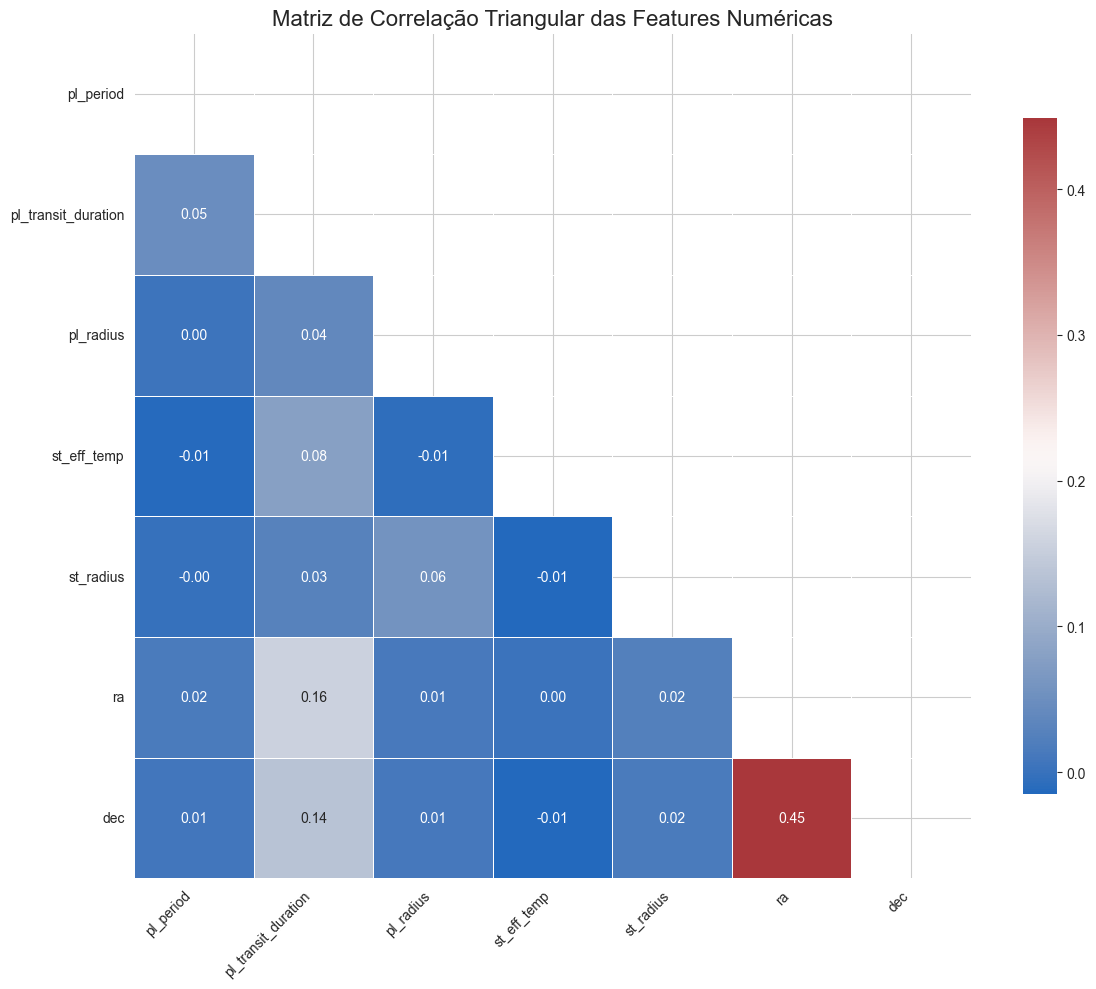

In [31]:


# %%
# ==============================================================================
# 4. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
# ==============================================================================

# # --- Informações Gerais e Estatísticas Descritivas ---
print("\n--- Informações Gerais do Dataset ---")
final_df.info()

print("\n--- Estatísticas Descritivas ---")
display(final_df.describe())

# --- Verificação de Valores Nulos ---
print("\n--- Contagem de Valores Nulos por Coluna ---")
print(final_df.isnull().sum().sort_values(ascending=False))

# # --- Distribuição da Variável Alvo e da Origem dos Dados ---
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# sns.countplot(x='isPlanet', data=final_df)
# plt.title('Distribuição da Variável Alvo (isPlanet)')
# plt.xlabel('0: Falso Positivo | 1: Planeta/Candidato')

# plt.subplot(1, 2, 2)
# sns.countplot(x='source', data=final_df, order=final_df['source'].value_counts().index)
# plt.title('Distribuição da Origem dos Dados')
# plt.tight_layout()
# plt.show()

# # # --- Distribuição das Features Numéricas ---
numeric_features = final_df.select_dtypes(include=np.number).columns.drop('isPlanet')
# for col in numeric_features:
#     plt.figure(figsize=(14, 6))
    
#     # Histograma com escala linear
#     plt.subplot(1, 2, 1)
#     sns.histplot(data=final_df, x=col, hue='isPlanet', kde=True, palette='viridis')
#     plt.title(f'Distribuição de {col} (Escala Linear)')
    
#     # Histograma com escala logarítmica (útil para dados com grande amplitude)
#     plt.subplot(1, 2, 2)
#     # Adicionar um pequeno valor para evitar log(0)
#     log_data = np.log1p(final_df[col].dropna())
#     sns.histplot(x=log_data, hue=final_df.loc[final_df[col].notna(), 'isPlanet'], kde=True, palette='plasma')
#     plt.title(f'Distribuição de {col} (Escala Log)')
#     plt.xlabel(f'log({col})')
    
#     plt.tight_layout()
#     plt.show()

# --- Matriz de Correlação (VERSÃO MELHORADA) ---
plt.figure(figsize=(12, 10))

# 1. Calcula a matriz de correlação normalmente
correlation_matrix = final_df[numeric_features].corr()

# 2. Cria uma máscara para o triângulo superior (incluindo a diagonal)
#    - np.ones_like(correlation_matrix, dtype=bool) cria uma matriz do mesmo tamanho, toda com 'True'.
#    - np.triu(...) transforma essa matriz, mantendo 'True' apenas na diagonal superior.
#    - O heatmap do seaborn usa essa máscara para NÃO desenhar as células onde o valor é 'True'.
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 3. Desenha o heatmap com as melhorias aplicadas
sns.heatmap(
    correlation_matrix,
    mask=mask,              # Aplica a máscara para esconder a parte superior e a diagonal
    annot=True,             # Mantém a anotação dos valores
    fmt=".2f",              # Formata os números com duas casas decimais
    cmap='vlag',            # Uma paleta de cores divergente e profissional (azul para negativo, vermelho para positivo)
    linewidths=.5,          # Adiciona uma pequena linha divisória entre as células
    cbar_kws={"shrink": .8} # Diminui um pouco o tamanho da barra de cores lateral
)

# 4. Ajustes finais de layout para melhor visualização
plt.title('Matriz de Correlação Triangular das Features Numéricas', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotaciona os labels do eixo X para não se sobreporem
plt.yticks(rotation=0)              # Mantém os labels do eixo Y na horizontal
plt.tight_layout()                  # Ajusta o plot para garantir que tudo caiba na figura
plt.show()

In [32]:
# ==============================================================================
# 4. PREPARAÇÃO PARA MODELAGEM (VERSÃO ATUALIZADA COM ID)
# ==============================================================================
from sklearn.model_selection import GroupShuffleSplit

# --- Criar um ID de Agrupamento (star_id) ---
data_final['star_id'] = data_final['ra'].astype(str) + '_' + data_final['dec'].astype(str)


# Numero total de linhas
num_rows = data_final.shape[0]
print(f"Número total de linhas no dataset: {num_rows}")

# Numero de estrelas unicas
num_stars = data_final['star_id'].nunique()
print(f"\nNúmero de sistemas estelares únicos (star_id): {num_stars}")

# --- Separar colunas de features, metadados e alvo ---
# O ID do trânsito é um metadado, não uma feature para o modelo aprender!
metadata_cols = ['transit_id', 'star_id', 'source', 'ra', 'dec']
target_col = 'isPlanet'
feature_cols = [col for col in data_final.columns if col not in metadata_cols + [target_col]]

print("Features que serão usadas no modelo:", feature_cols)

# --- Dividir os dados em treino e teste (hold-out) usando GroupShuffleSplit ---
# Esta é a forma mais correta de garantir que não há vazamento de dados
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_idx, test_idx = next(gss.split(data_final[feature_cols], data_final[target_col], data_final['star_id']))

train_df = data_final.iloc[train_idx]
test_df = data_final.iloc[test_idx]

print(f"\nDados separados (respeitando os sistemas estelares):")
print(f"  - Conjunto de Treino/Validação: {train_df.shape[0]} amostras")
print(f"  - Conjunto de Teste (Hold-Out): {test_df.shape[0]} amostras")

# --- Exportar o conjunto de teste para um CSV (COM O ID) ---
csv_filename = 'dados_para_predicao.csv'
# Criamos o CSV apenas com o ID e as features necessárias para a predição
test_df[['transit_id'] + feature_cols].to_csv(csv_filename, index=False)
print(f"\nDados de teste com ID salvos em '{csv_filename}'")

# --- Preparar variáveis para o restante do script de treinamento ---
X = train_df[feature_cols]
y = train_df[target_col]
groups = train_df['star_id']

Número total de linhas no dataset: 16346

Número de sistemas estelares únicos (star_id): 14725
Features que serão usadas no modelo: ['pl_period', 'pl_transit_duration', 'pl_radius', 'st_eff_temp', 'st_radius']

Dados separados (respeitando os sistemas estelares):
  - Conjunto de Treino/Validação: 13895 amostras
  - Conjunto de Teste (Hold-Out): 2451 amostras

Dados de teste com ID salvos em 'dados_para_predicao.csv'


In [ ]:
# ==============================================================================
# SEÇÕES 1 a 4: Carga, Limpeza, EDA e Preparação dos Dados
# (COLE O SEU CÓDIGO ORIGINAL DAS SEÇÕES 1 A 4 AQUI)
# ...
# O código abaixo assume que as variáveis X, y, groups e test_df
# já foram criadas exatamente como no seu script original.
# ==============================================================================

# %%
# ==============================================================================
# 5. BUSCA DO MELHOR MODELO COM AUTO-SKLEARN
# (Esta seção substitui sua otimização com Optuna e a lista de modelos)
# ==============================================================================
import autosklearn.classification
from sklearn.model_selection import StratifiedGroupKFold

print("\n--- Iniciando a busca pelo melhor pipeline com Auto-sklearn ---")

# 1. Definir a mesma estratégia de validação cruzada que você usou
# O auto-sklearn vai usar essa estratégia internamente para avaliar os modelos.
cv_strategy = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

# 2. Configurar o classificador do Auto-sklearn
# O parâmetro mais importante é 'time_left_for_this_task' (em segundos).
# Para um teste rápido, use 300 (5 min). Para uma busca mais séria, use 3600 (1h) ou mais.
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=3600,  # Tempo total em segundos para a busca
    per_run_time_limit=300,        # Tempo limite para treinar um único modelo
    memory_limit=4096,             # Limite de memória em MB
    n_jobs=-1,                     # Usar todos os cores da CPU
    seed=SEED,
    resampling_strategy=cv_strategy, # AQUI passamos nossa estratégia de CV
    resampling_strategy_arguments={'groups': groups}, # E os grupos para ela usar
    metric=autosklearn.metrics.roc_auc, # Métrica a ser otimizada
    # Incluir apenas os melhores modelos para acelerar a busca (opcional)
    include={
        'classifier': ["lgbm", "xgboost", "random_forest", "extra_trees"],
    }
)

# 3. Executar a busca e o treinamento
# IMPORTANTE: Passe os dados SEM PADRONIZAÇÃO (X, não X_scaled).
# O Auto-sklearn testa diferentes pré-processadores (incluindo scalers) como
# parte do pipeline que ele otimiza.
print(f"Iniciando .fit() com um tempo limite de {automl.time_left_for_this_task / 60:.1f} minutos...")
automl.fit(X.copy(), y.copy()) # .copy() é uma boa prática
print("Treinamento com Auto-sklearn concluído!")


# 4. Mostrar os resultados da busca
print("\n--- Estatísticas da Busca do Auto-sklearn ---")
print(automl.sprint_statistics())

print("\n--- Leaderboard (Melhores Modelos Encontrados) ---")
# O leaderboard mostra o desempenho de cada pipeline testado na validação cruzada
leaderboard = automl.leaderboard()
display(leaderboard)

print("\n--- Composição do Modelo Final (Ensemble) ---")
# O modelo final do auto-sklearn é um "ensemble" dos melhores modelos encontrados
print(automl.show_models())

# %%
# ==============================================================================
# 6. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE (Hold-Out)
# ==============================================================================
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, average_precision_score
)
import json

print("\n--- Avaliando o modelo final do Auto-sklearn no conjunto de teste ---")

# Preparar os dados de teste (sem o scaler, pois o automl já tem um pipeline completo)
X_test_holdout = test_df[feature_cols]
y_test_holdout = test_df[target_col]

# Fazer as previsões de probabilidade
y_pred_proba_holdout = automl.predict_proba(X_test_holdout)[:, 1]

# Fazer as previsões de classe (usando o threshold padrão de 0.5)
y_pred_holdout = automl.predict(X_test_holdout)

# Adicionar previsões ao dataframe de teste para análise por satélite
test_df['prediction'] = y_pred_holdout
test_df['prediction_proba'] = y_pred_proba_holdout

# --- Calcular Métricas (código similar ao seu original) ---
global_report = classification_report(y_test_holdout, y_pred_holdout, output_dict=True, zero_division=0)
global_roc_auc = roc_auc_score(y_test_holdout, y_pred_proba_holdout)
global_prc_auc = average_precision_score(y_test_holdout, y_pred_proba_holdout)

global_test_metrics = {
    'acuracia': global_report.get('accuracy', 0),
    'auc_roc': global_roc_auc,
    'auc_prc': global_prc_auc,
    'recall_planeta': global_report.get('1', {}).get('recall', 0),
    'precisao_planeta': global_report.get('1', {}).get('precision', 0),
    'f1_score_planeta': global_report.get('1', {}).get('f1-score', 0)
}

# Criar a tabela de métricas para exibição
metrics_df = pd.DataFrame([global_test_metrics], index=['Auto-sklearn Global'])
metrics_df.columns = ['Acurácia', 'AUC ROC', 'AUC PRC', 'Recall (Planeta)', 'Precisão (Planeta)', 'F1 (Planeta)']

print("\nTabela de Métricas Finais no Conjunto de Teste:")
display(metrics_df.style.format('{:.4f}').background_gradient(cmap='viridis', axis=1))

# %%
# ==============================================================================
# 7. SALVAR O MODELO FINAL
# ==============================================================================
import joblib

model_filename = 'automl_modelo_exoplanetas.joblib'

# Salvar o objeto automl inteiro. Ele contém todo o pipeline:
# pré-processadores, modelos e lógica do ensemble.
joblib.dump(automl, model_filename)
print(f"Modelo completo do Auto-sklearn salvo em: '{model_filename}'")


# %%
# ==============================================================================
# 8. ANÁLISE DE IMPORTÂNCIA DAS FEATURES (SHAP)
# ==============================================================================
import shap

print("\n--- Análise de Features com SHAP ---")
# CUIDADO: O modelo final do auto-sklearn é um ensemble. Se ele contiver modelos
# que não são baseados em árvores (ex: SVM), o TreeExplainer dará erro.
# Uma abordagem mais segura é usar o KernelExplainer, mas ele é mais lento.

# Vamos tentar extrair apenas os modelos baseados em árvore do ensemble para usar o TreeExplainer
# Nota: Esta é uma abordagem avançada. Se falhar, o KernelExplainer é a alternativa.
try:
    # Acessa o pipeline final ajustado
    pipeline = automl.get_models_with_weights()[0][1]
    
    # Encontra o estimador final dentro do pipeline
    # O nome pode variar, mas 'classifier' é o comum
    final_estimator = pipeline.steps[-1][1]

    print("Tipo do estimador final encontrado:", type(final_estimator))

    explainer = shap.TreeExplainer(final_estimator)
    
    # O SHAP precisa dos dados transformados pelo pipeline do auto-sklearn
    # Para isso, removemos o último passo (o classificador) e aplicamos `transform`
    preprocessor = pipeline.copy().pop(-1)
    X_test_transformed = preprocessor.transform(X_test_holdout)
    
    shap_values = explainer.shap_values(X_test_transformed)
    
    print("Gerando gráficos SHAP...")
    # O summary_plot precisa dos dados antes da transformação para exibir os nomes corretos
    shap.summary_plot(shap_values, X_test_holdout, plot_type="bar", show=True)

except Exception as e:
    print(f"\nNão foi possível usar o TreeExplainer diretamente (erro: {e}).")
    print("Isso pode acontecer se o ensemble final contiver modelos não-árvore.")
    print("Considere usar o shap.KernelExplainer, que é mais lento, mas agnóstico ao modelo.")